# Check Why Constraints are Violated on Next Iteration

In [89]:
import importlib
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

import utl_ipop as udf
importlib.reload(sys.modules['utl_ipop'])

sns.set_palette(sns.color_palette("muted", 10))

<module 'utl_ipop' from '/Users/joe/Documents/c01_wxds/a05_ipop/utl_ipop.py'>

In [73]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [74]:
import numbers
from scipy import optimize

## Data Prep

In [3]:
# Load data
scored_base = pd.read_parquet('data/decision_model_base_999.parquet')

# Initial best offers
scored_best = pd.read_parquet('data/decision_model_999.parquet')

# Analysis without missing crns
# Missing crns in best offer were assigned to random group
crn_missing = list(set(scored_base['crn']) - set(scored_best['crn']))
cond = scored_base['crn'].isin(crn_missing)

# Analysis without missing crn
scored_base = scored_base[~cond]
scored_base.shape
scored_base['crn'].nunique()
scored_best['crn'].nunique()

(279114, 27)

5044

5044

## iPop

In [5]:
# lb=[-2]; ub=[2,2]
lb=[-2]; ub=[2.7, 2.7]

res = udf.ipop_optimise(scored_best, scored_base, lb=lb, ub=ub, verbose=True)

iter: 1, x_opt: 1.0018
iter: 2, x_opt: 0.0083
>> IPOP terminated: constraint(s) met
>> Final state: ['profit_gain: 10.16%', 'cost_saving: 23.19%', 'inc_sales_loss: 0.07%']
>> Constraints: ['p_rdm_loss: 2.74%', 'p_open_loss: 2.0%', 'p_unsub_loss: 0.92%']


In [90]:
# lb=[-2]; ub=[2,2]
lb=[-2]; ub=[2.7, 2.7]

res = udf.ipop_optimise(scored_best, scored_base, lb=lb, ub=ub, verbose=True)

iter: 1, x_opt: 1.0018
iter: 2, x_opt: 0.0083
>> IPOP terminated: constraint(s) met
>> Final state: ['profit_gain: 10.16%', 'cost_saving: 23.19%', 'inc_sales_loss: 0.07%']
>> Constraints: ['p_rdm_loss: 2.74%', 'p_open_loss: 2.0%', 'p_unsub_loss: 0.92%']


In [84]:
scored_best['inc_sales'].sum()

7075.2695

In [83]:
res.best_['inc_sales'].sum()

7070.1475

In [85]:
(scored_best['p_rdm'].sum() - res.best_['p_rdm'].sum()) / scored_best['p_rdm'].sum()

0.026136067

In [86]:
(scored_best['inc_sales'].sum() - res.best_['inc_sales'].sum()) / scored_best['inc_sales'].sum()

0.00072394

## iPop Examined

In [54]:
best = scored_best.copy()
_base = scored_base.copy()
score="inc_sales"
n_loop=25
change_lim=3
verbose=True
out="all"
x0=0.5

In [55]:
opt_cols = [
    "crn",  # 'offerId',
    "inc_sales", "target_cost", "score",
    "p_rdm", "p_open", "p_unsub",
]
sort_cols = ["crn", score, "target_cost", "score"]
sort_dir = [True, False, True, False]
metric_cols = ["inc_sales", "target_cost"]
constr_cols = ["p_rdm", "p_open", "p_unsub"]

base = _base[opt_cols]
best = best[opt_cols]

# Initial best offer metrics and constraints
best0_metrics = best[metric_cols].sum()
best0_metrics["profit"] = best0_metrics[0] - best0_metrics[1]
best0_constr_metrics = best[constr_cols].sum()

# Sort base by "inc_sales"; tie break on "target_cost", "score"
base.sort_values(by=sort_cols, ascending=sort_dir, inplace=True)

base["rank"] = (
    base.groupby("crn")[sort_cols[1]]
    .rank(ascending=sort_dir[1], method="first")
    .astype("uint8")
)
base["rank_best"] = 1
base["rank_2nd"] = 2
base["no_change"] = 0

offer_cnt = base.groupby("crn")["rank"].max().values
offer_cnt_explode = [[x] * x for x in offer_cnt]
base["offer_cnt"] = [x for ls in offer_cnt_explode for x in ls]

## Loop

In [56]:
i = 0

In [57]:
cond_top2 = (
    (base["rank"] == base["rank_best"]) |
    (base["rank"] == base["rank_2nd"])
)
top2 = base[cond_top2]

# Top 2 diff for SC gradient
top2_diff = top2[metric_cols] - \
    top2.groupby("crn")[metric_cols].shift()
top2 = top2.merge(
    top2_diff, left_index=True, right_index=True,
    suffixes=("", "_diff")
)
top2["sc_grad"] = top2["inc_sales_diff"] / top2["target_cost_diff"]

x_opt = optimize.fmin_cobyla(
    udf.obj_func,
    x0,
    udf.constr_ineq,
    args=(top2, best0_metrics),
    consargs=(top2, best0_constr_metrics, lb, ub),
)
best = udf.choose_offer(top2, x_opt)

# Check constraints violation where values impossible for all x
con = udf.constr_ineq(x_opt, top2, best0_constr_metrics, lb, ub)

if verbose:
    print(f"iter: {i+1}, x_opt: {x_opt.round(4)}")

# -------------------------------------------------
# Update base table where best has changed
# -------------------------------------------------
cond_offers_exist = base["rank_2nd"] < base["offer_cnt"]

# Check if num.offer.changes has reached limit
crn_changes_open = base.groupby("crn")["no_change"].sum() < change_lim
cond_changes_open = (
    base["crn"].isin(crn_changes_open[crn_changes_open].index)
    & cond_offers_exist
)

# Offer change
cond = best["rank"] == best["rank_2nd"]
crn_upd = best.loc[cond, "crn"]
cond_change = base["crn"].isin(crn_upd)

# Update best offer where offer changed (2nd becomes best)
cond = cond_changes_open & cond_change
base["rank_best"] = np.where(cond, base["rank_2nd"], base["rank_best"])

# Flag no offer change
cond = cond_changes_open & ~cond_change & (
    base["rank"] == base["rank_2nd"])
base["no_change"] = np.where(cond, 1, base["no_change"])

# Identify next 2nd best
base["rank_2nd"] = np.where(
    cond_changes_open, base["rank_2nd"] + 1, base["rank_2nd"])

iter: 1, x_opt: 1.0018


In [58]:
class Res(object):
        pass
res = Res()
res.rpt_ = udf.obj_func(x_opt, top2, best0_metrics, "rpt")
res.con_ = udf.constr_ineq(x_opt, top2, best0_constr_metrics,
                        lb, ub, scenario="rpt")

keys = list(res.rpt_.keys())[5:2:-1]
values = [res.rpt_[k][0].round(2) for k in keys]
txt = [k.rpartition("_")[0] + ": " + str(v) +
        "%" for k, v in zip(keys, values)]
print(f'>> Final state: {txt}')

# constraints
txt = [k + "_loss: " + str(v.round(2)) + "%" for k,
        v in zip(constr_cols, res.con_)]
print(f'>> Constraints: {txt}')

>> Final state: ['profit_gain: 10.12%', 'cost_saving: 23.09%', 'inc_sales_loss: 0.07%']
>> Constraints: ['p_rdm_loss: 2.61%', 'p_open_loss: 1.99%', 'p_unsub_loss: 0.92%']


In [36]:
res.rpt_ = udf.obj_func(x_opt, top2, best0_metrics, "rpt")
res.con_ = udf.constr_ineq(x_opt, top2, best0_constr_metrics,
                        lb, ub, scenario="rpt")

keys = list(res.rpt_.keys())[5:2:-1]
values = [res.rpt_[k][0].round(2) for k in keys]
txt = [k.rpartition("_")[0] + ": " + str(v) +
        "%" for k, v in zip(keys, values)]
print(f'>> Final state: {txt}')

# constraints
txt = [k + "_loss: " + str(v.round(2)) + "%" for k,
        v in zip(constr_cols, res.con_)]
print(f'>> Constraints: {txt}')

>> Final state: ['profit_gain: 10.16%', 'cost_saving: 23.19%', 'inc_sales_loss: 0.07%']
>> Constraints: ['p_rdm_loss: 2.74%', 'p_open_loss: 2.0%', 'p_unsub_loss: 0.92%']


## Plot

In [59]:
InteractiveShell.ast_node_interactivity = "last"

In [60]:
x = np.linspace(-0.5, 2.5, 100)
y = -udf.obj_func(x, top2, best0_metrics, scenario='opt')

best_profit = scored_best['inc_sales'].sum() - scored_best['target_cost'].sum()
y_perc = y / best_profit * 100

con_ = udf.constr_ineq(x, top2, best0_constr_metrics,
                        lb, ub, scenario="rpt")
con = con_.reshape(3,-1)

<function matplotlib.pyplot.show(*args, **kw)>

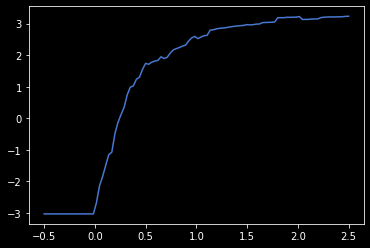

In [61]:
plt.plot(x, con[0], '-')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

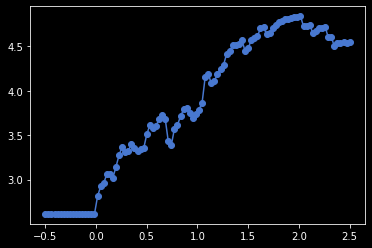

In [40]:
plt.plot(x, con[0], '-')
plt.show

In [49]:
cond_top2 = (
    (base["rank"] == base["rank_best"]) |
    (base["rank"] == base["rank_2nd"])
)
top2 = base[cond_top2]

# Top 2 diff for SC gradient
top2_diff = top2[metric_cols] - \
    top2.groupby("crn")[metric_cols].shift()
top2 = top2.merge(
    top2_diff, left_index=True, right_index=True,
    suffixes=("", "_diff")
)
top2["sc_grad"] = top2["inc_sales_diff"] / top2["target_cost_diff"]

In [50]:
y = -udf.obj_func(x, top2, best0_metrics, scenario='opt')

best_profit = scored_best['inc_sales'].sum() - scored_best['target_cost'].sum()
y_perc = y / best_profit * 100

con_ = udf.constr_ineq(x, top2, best0_constr_metrics,
                        lb, ub, scenario="rpt")

<function matplotlib.pyplot.show(*args, **kw)>

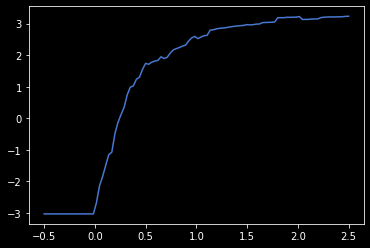

In [52]:
plt.plot(x, con[0], '-')
plt.show

In [63]:
top2['inc_sales'].sum()

12206.308

In [65]:
cond_top2 = (
    (base["rank"] == base["rank_best"]) |
    (base["rank"] == base["rank_2nd"])
)
top2 = base[cond_top2]
top2['inc_sales'].sum()

11623.711

In [66]:
# Top 2 diff for SC gradient
top2_diff = top2[metric_cols] - \
    top2.groupby("crn")[metric_cols].shift()
top2 = top2.merge(
    top2_diff, left_index=True, right_index=True,
    suffixes=("", "_diff")
)
top2["sc_grad"] = top2["inc_sales_diff"] / top2["target_cost_diff"]

In [68]:
y = -udf.obj_func(x, top2, best0_metrics, scenario='opt')

best_profit = scored_best['inc_sales'].sum() - scored_best['target_cost'].sum()
y_perc = y / best_profit * 100

con_ = udf.constr_ineq(x, top2, best0_constr_metrics,
                        lb, ub, scenario="rpt")
con = con_.reshape(3,-1)

<function matplotlib.pyplot.show(*args, **kw)>

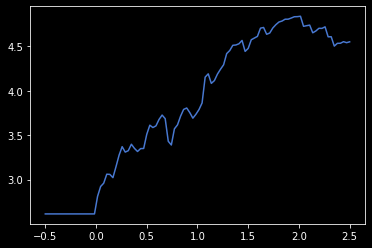

In [69]:
plt.plot(x, con[0], '-')
plt.show

In [71]:
con[0][:20]

array([2.6135147, 2.6135147, 2.6135147, 2.6135147, 2.6135147, 2.6135147,
       2.6135147, 2.6135147, 2.6135147, 2.6135147, 2.6135147, 2.6135147,
       2.6135147, 2.6135147, 2.6135147, 2.6135147, 2.6135147, 2.8108823,
       2.9224675, 2.9595704], dtype=float32)